# Inteligencia Artificial

# Clase 23 - Modelos generativos II
## Autoencoders variacionales

En esta práctica replicaremos la estructura del autoencoder pero agregándo una modificación para que el espacio en el que se ubican las representaciones intermedias de las imágenes del dataset sea (localmente) continuo.

La primera parte de esta notebook replica la notebook anterior, hasta la parte en la que construimos el encoder.

In [1]:
import os

notebook_dir = os.getcwd()
faces_dir = os.path.join(notebook_dir, "data_faces/img_align_celeba")
attrs_file = os.path.join(notebook_dir, "list_attr_celeba.txt")

In [2]:
import pandas as pd

In [3]:
attrs_df = pd.read_csv(attrs_file, delim_whitespace=True, skiprows=1)

In [4]:
attrs_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
n_images = len(os.listdir(faces_dir))
n_images

202599

In [6]:
os.listdir(faces_dir)[:10]

['105222.jpg',
 '083302.jpg',
 '095653.jpg',
 '009865.jpg',
 '004042.jpg',
 '116294.jpg',
 '151527.jpg',
 '161766.jpg',
 '013770.jpg',
 '110589.jpg']

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def get_attrs(filename):
    row = attrs_df.loc[filename, :]
    return [attr for attr in row.index if row[attr]==1]

In [9]:
get_attrs(os.listdir(faces_dir)[0])

['Bags_Under_Eyes',
 'Big_Nose',
 'Chubby',
 'Double_Chin',
 'Goatee',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Receding_Hairline',
 'Smiling']

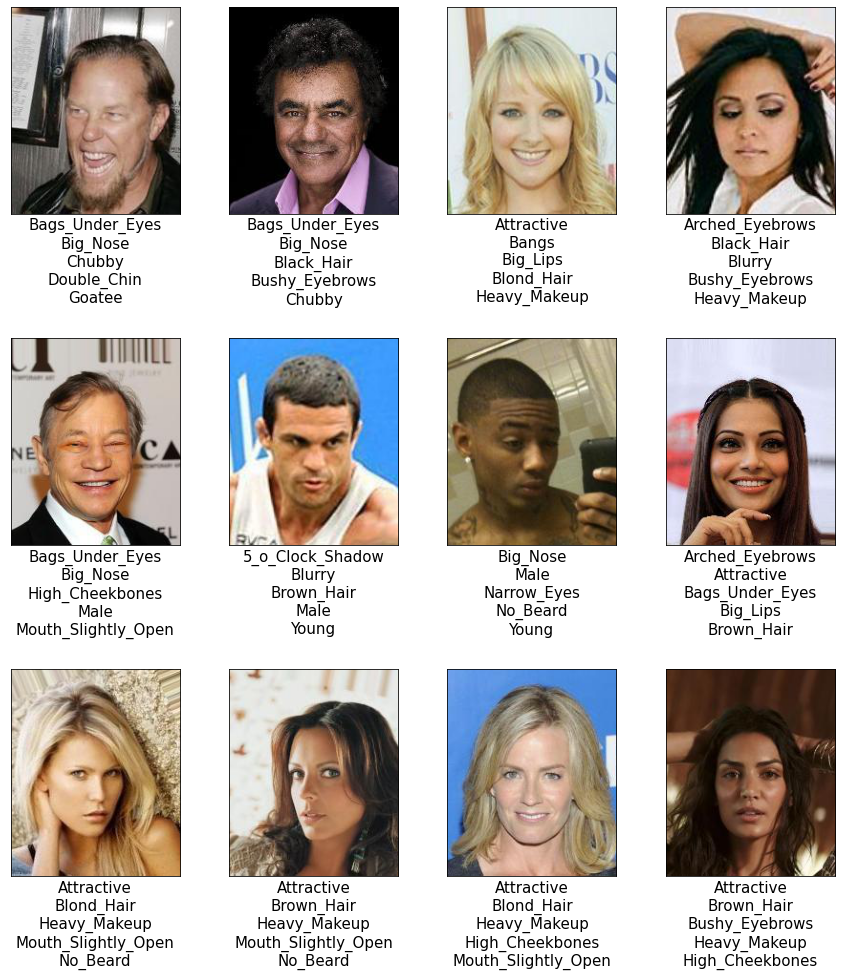

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(15,16))
fig.subplots_adjust(hspace=0.6)
for i, ax in enumerate(axes.flatten()):
    filename = os.listdir(faces_dir)[i]
    img = plt.imread(os.path.join(faces_dir, filename))
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("\n".join(get_attrs(filename)[:5]), fontsize=15)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
data_gen = ImageDataGenerator(rescale=1./255)

In [13]:
batch_size=128
data_flow = data_gen.flow_from_directory(os.path.join(faces_dir,os.pardir), 
                                         class_mode="input", 
                                         subset="training",
                                         batch_size=batch_size,
                                         target_size=(128,128)                         
                                        )

Found 202599 images belonging to 1 classes.


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv2DTranspose, Lambda
from tensorflow.keras.layers import LeakyReLU, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

## El encoder variacional

En este caso, la red del encoder debe generar 2 salidas: $\mu$ y $\sigma$.

In [15]:
encoder_input = Input(shape=(128,128,3), name='encoder_input')
conv_layer_0 = Conv2D(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_0')
x = conv_layer_0(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_1 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_1')
x = conv_layer_1(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_2 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_2')
x = conv_layer_2(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_3 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_3')
x = conv_layer_3(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]
print(f"Antes de aplanar, el tensor tiene forma {K.int_shape(x)}")

x = Flatten()(x)

# Ahora tendremos 2 salidas: una para la media
encoder_mu = Dense(200, name="encoder_mu")(x)

# Y otra para el logaritmo de la varianza
encoder_log_var = Dense(200, name="encoder_log_var")(x)

# Armamos el modelo del encoder
encoder = Model(encoder_input, [encoder_mu, encoder_log_var])

Antes de aplanar, el tensor tiene forma (None, 8, 8, 64)


### El decoder

La estructura del decoder es exactamente la misma que en el autoencoder.

In [16]:
decoder_input = Input(shape=(200,), name="decoder_input")

# Debemos reconstruir el camino inverso del encoder
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

# Expandimos el ancho y alto del volumen usando Conv2DTranspose
conv_t_layer = Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_0'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_t_layer = Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_1'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_t_layer = Conv2DTranspose(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_2'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Volvemos a llevar la imagen reconstruida a 3 canales 
conv_t_layer = Conv2DTranspose(
                filters = 3,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t3'
                )
x = conv_t_layer(x)
# En este caso necesitamos que la salida esté entre 0 y 1
decoder_output = Activation("sigmoid")(x)

decoder = Model(decoder_input, decoder_output, name="decoder")

### Mecanismo de muestreo y función de costo

Vimos que ahora el encoder entrega 2 salidas, pero el decoder sigue recibiendo una sola.

¿Qué pasa en el medio?

Las salidas $\mu$ (mu) y $\sigma$ (log_var) del encoder son utilizadas como parámetros de una distribución normal para tomar una muestra aleatoria. Dicha muestra será la entrada del decoder.

In [ ]:
def sampling(mu, log_var):
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * epsilon

Ahora debemos definir la función de costo que optimizaremos. Dicha función estará compuesta por dos componentes:
- la pérdida de reconstrucción: medirá cuán bien el modelo está codificando y luego reconstruyendo las imágenes del dataset
- la divergencia de Kulback-Liebler: medirá cuán lejos de una distribución N(0,1) están las representaciones intermedias.

El primer componente de la pérdida actuará sobre todo el modelo, mientras que el segundo sólo sobre el encoder.

In [17]:
# Pérdida de reconstrucción
def r_loss(img_i, img_r):
    return K.mean(K.square(img_r - img_i), axis=[1,2,3])

# Divergencia KL
def kl_loss(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.square(mu)- K.exp(log_var), axis = 1)

Combinamos ambas pérdidas en una sola utilizando un factor de ponderación para medir la importancia de cada término en la pérdida global.

In [18]:
def vae_loss(encoder, decoder, input_img):
    mu, log_var = encoder(input_img)
    encoded = sampling(mu, log_var)
    decoded = decoder(encoded)
    
    loss = kl_loss(mu, log_var) + r_loss(input_img, decoded) * 10000
    return K.mean(loss)

Tomamos una imágen de muestra para ver el progreso del entrenamiento.

In [45]:
sample_file = attrs_df.sample().index[0]
img = cv2.imread(os.path.join(faces_dir,sample_file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(img, (128,128))/255


Entrenamos el modelo siguiendo la nueva metodología propuesta por Tensorflow 2

Epoch: 4 - Loss: 213.52255: 100%|██████████| 1583/1583 [04:36<00:00,  5.72it/s]


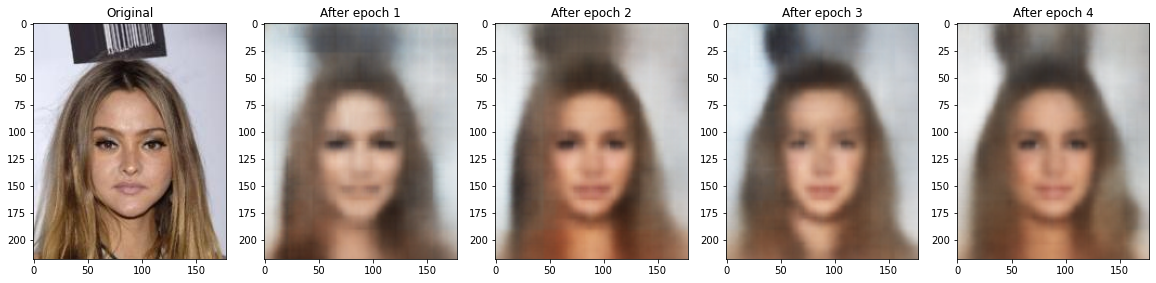

In [20]:
# Definimos la cantidad de epochs
epochs = 4

# Generamos los objetos para plotear las imágenes
fig, axes = plt.subplots(1, epochs+1, figsize=(20,5))
axes[0].imshow(img)
axes[0].set_title("Original")

# Instanciamos el optimizador
optimizer = Adam(learning_rate=0.0005)

# Ingresamos al loop de entrenamiento

# Entrenaremos por epochs
for e in range(epochs):

    # Iteramos por todos los batches
    pbar = tqdm(range(len(data_flow)))
    for i in pbar:
        
        # Computamos la función de costo dentro del contexto GradientTape
        # para registrar las operaciones y poder calcular las derivadas parciales
        with tf.GradientTape() as tape:
            batch = data_flow.next()[0]
            loss = vae_loss(encoder, decoder, batch)
        
        # Unificamos los parámetros que debemos ajustar del encoder y del decoder
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        # Calculamos los gradientes
        grads = tape.gradient(loss, trainable_variables)

        # Aplicamos los gradientes a los parámetros de la red
        optimizer.apply_gradients(zip(grads, trainable_variables))
        
        pbar.set_description("Epoch: {} - Loss: {:06.5f}".format(e+1, loss))

    # Generate a new output for the same image
    mu, log_var = encoder(np.expand_dims(input_image, axis=0))
    encoded = sampling(mu, log_var)
    decoded = decoder(encoded)
    reconstructed_image = cv2.resize(decoded[0].numpy(), (178,218))
    axes[e+1].imshow(reconstructed_image)
    axes[e+1].set_title(f"After epoch {e+1}")


In [32]:
epochs = 20
for e in range(epochs):

    pbar = tqdm(range(len(data_flow)))
    for i in pbar:
        with tf.GradientTape() as tape:
            batch = data_flow.next()[0]
            loss = vae_loss(encoder, decoder, batch)
            
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        grads = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(grads, trainable_variables))
        pbar.set_description("Epoch: {} - Loss: {:06.5f}".format(e+1, loss))

Epoch: 20 - Loss: 208.23907: 100%|██████████| 1583/1583 [04:33<00:00,  5.79it/s]


In [43]:
epochs = 5
for e in range(epochs):

    pbar = tqdm(range(len(data_flow)))
    for i in pbar:
        with tf.GradientTape() as tape:
            batch = data_flow.next()[0]
            loss = vae_loss(encoder, decoder, batch)
            
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        grads = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(grads, trainable_variables))
        pbar.set_description("Epoch: {} - Loss: {:06.5f}".format(e+1, loss))

Epoch: 5 - Loss: 186.28078: 100%|██████████| 1583/1583 [05:30<00:00,  4.79it/s]


Generemos una nueva muestra luego de más epochs

Text(0.5, 1.0, 'Reconstruida')

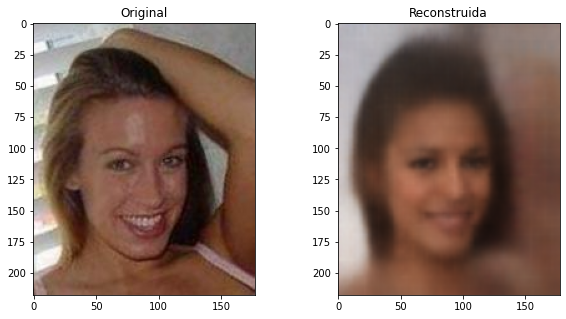

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img)
axes[0].set_title("Original")
mu, log_var = encoder(np.expand_dims(input_image, axis=0))
encoded = sampling(mu, log_var)
decoded = decoder(encoded)
reconstructed_image = cv2.resize(decoded[0].numpy(), (178,218))
axes[1].imshow(reconstructed_image)
axes[1].set_title(f"Reconstruida")

### Generando imágenes nuevas

Como ahora sabemos que la distribución de representaciones intermedias en el espacio latente intanta asemejarse a una distribución normal, podemos tomar una muestra de dicha distribución y ver qué imágen genera.

In [47]:
noise = tf.random.normal(shape=(1,200))

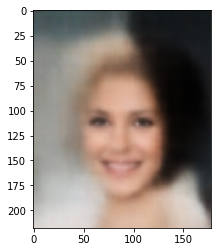

In [53]:
decoded = decoder(noise)
reconstructed_image = cv2.resize(decoded[0].numpy(), (178,218))
plt.imshow(reconstructed_image)

Vemos que, si bien el resultado todavía deja mucho que desear, se mucho más identificable que es una imagen de un rostro.